# Library Import

* I worked on the Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
## basic data process modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

## for problems
import statsmodels.api as sm

## others
import warnings
import os
from typing import List, Tuple, Dict, Any
from collections.abc import Callable

warnings.filterwarnings('ignore')
os.getcwd()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'/content'

# Global Variables

In [3]:
os.chdir('/content/drive/MyDrive/GSDS/2022-1/MLDL/Homework1')
PATH = os.getcwd()
print(PATH)

## random seed
RANDOM_STATE = 20140801

# set 20% of the dataset as a test set
TEST_SIZE = 0.2

/content/drive/MyDrive/GSDS/2022-1/MLDL/Homework1


# Metrics

In [4]:
def classification_error(y_true:np.ndarray, y_pred:np.ndarray) -> float:
    """
    If an element in y_true equals to the corresponding one in y_pred, returns True, otherwise False. 
    Then convert the boolean type into the integer type
    """
    correct = (y_true == y_pred).astype(np.int16).sum() # the number of correct classfication
    misclassified = 1 - (correct / y_true.shape[0])
    return misclassified

In [5]:
def class_metrics(y_true:np.ndarray, y_pred:np.ndarray, metric:str) -> float:

    tp = ((y_true == 1) & (y_pred == 1)).astype(np.int16).sum()
    fp = ((y_true == 0) & (y_pred == 1)).astype(np.int16).sum()
    fn = ((y_true == 1) & (y_pred == 0)).astype(np.int16).sum()
    tn = ((y_true == 0) & (y_pred == 0)).astype(np.int16).sum()

    metric = metric.lower()
    if metric == 'precision' or metric == 'ppv':
        return tp / (tp + fp)
    if metric == 'recall' or metric == 'sensitivity' or metric == 'tpr':
        return tp / (tp + fn)
    if metric == 'fpr':
        return fp / (fp + tn)
    if metric == 'fnr':
        return fn / (fn + tp)

In [6]:
def precision_recall(y_true:np.ndarray, y_pred_proba:np.ndarray) -> Tuple[np.ndarray]:
    threshold = np.linspace(0, 1, num=y_true.shape[0])
    precision, recall = np.zeros(shape=(threshold.shape[0], )), np.zeros(shape=(threshold.shape[0], ))
    for i in range(threshold.shape[0]):
        th = threshold[i]
        y_pred = (y_pred_proba > th).astype(np.int16)
        prec = class_metrics(y_true, y_pred, metric='precision')
        rec = class_metrics(y_true, y_pred, metric='recall')
        precision[i] = prec
        recall[i] = rec
    return precision, recall, threshold

In [7]:
def f1_score(y_true:np.ndarray, y_pred:np.ndarray) -> float:
    precision = class_metrics(y_true, y_pred, metric='precision')
    recall = class_metrics(y_true, y_pred, metric='recall')
    return (2*precision*recall) / (precision+recall)

# Problem 1

## Data Import and Check

In [8]:
cs = pd.read_csv(f"{PATH}/Carseats.csv", engine='python', encoding='utf8')
cs.head()
print(cs.shape)

(400, 11)


* In this problem, the target variable is `Sales`.

* Here, we have three categorical variables: `ShelveLoc`, `Urban`, and `US`. Before fitting, we need to convert them into numerical variables. So let's check the values in each categorical variable except for the `ShelveLoc`, since we are not going to use the variable for this problem.

In [9]:
cat_features = ['Urban', 'US']
for cat in cat_features:
    print(f"Unique values of {cat}\t{cs[cat].unique()}")

Unique values of Urban	['Yes' 'No']
Unique values of US	['Yes' 'No']


* `Urban` and `US` are both binary categories. So we need just 1 dummy variable.

In [10]:
## convert into dummy variables

# dictionary for conversion
binary_dict = {'Yes': 1, 'No': 0}

# convert into dummy variables
cs['Urban'] = cs['Urban'].map(binary_dict)
cs['US'] = cs['US'].map(binary_dict)

In [11]:
cs.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,1,1
1,11.22,111,48,16,260,83,Good,65,10,1,1
2,10.06,113,35,10,269,80,Medium,59,12,1,1
3,7.40,117,100,4,466,97,Medium,55,14,1,1
4,4.15,141,64,3,340,128,Bad,38,13,1,0


Proportion of observations who live in Urban:70.5%


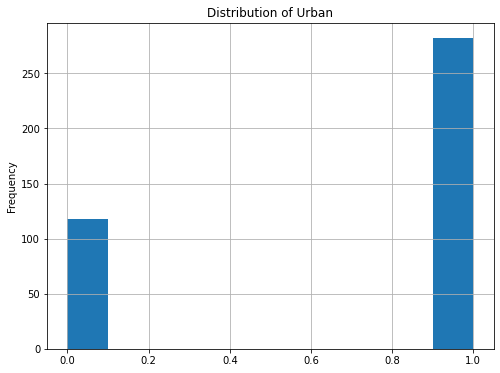

In [12]:
# check the distribution of the features
cs['Urban'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Urban')
print(f"Proportion of observations who live in Urban:{cs['Urban'].sum() * 100 / cs.shape[0]}%")

Proportion of observations who come from US:64.5%


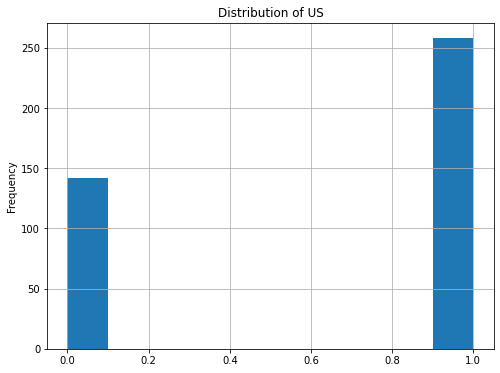

In [13]:
cs['US'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of US')
print(f"Proportion of observations who come from US:{cs['US'].sum() * 100 / cs.shape[0]}%")

Mean: 115.795	Standard Deviation: 23.676664378459755


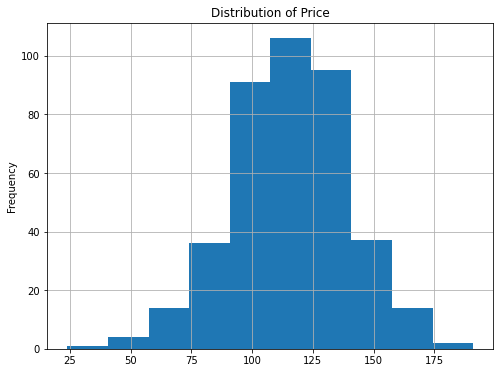

In [14]:
cs['Price'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Price')
print(f"Mean: {cs['Price'].mean()}\tStandard Deviation: {cs['Price'].std()}")

Mean: 7.496325	Standard Deviation: 2.8241150488068367


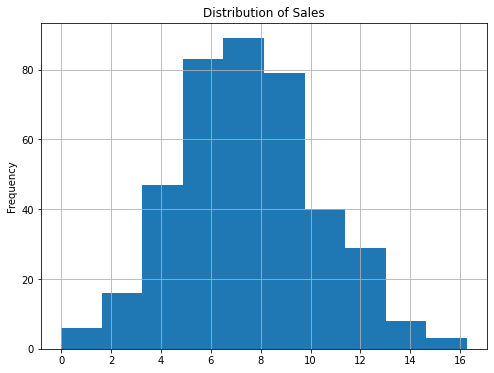

In [15]:
cs['Sales'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Sales')
print(f"Mean: {cs['Sales'].mean()}\tStandard Deviation: {cs['Sales'].std()}")

## Function Definition

* I'll define a function that implements linear regression and logistic regression using the `statsmodels` module.

In [16]:
## define a function for regression
def regression(X:Any, y:Any, constant:bool=True, logit:bool=False): 
    if constant:
        X = sm.add_constant(X)
    
    if logit:
        model = sm.Logit(y.astype(float), X.astype(float))
    else:
        model = sm.OLS(y.astype(float),X.astype(float))
        
    return model

## (a) Fitting a multiple regression model

In [17]:
# split into the independent variables and the target
X = cs[['Price', 'Urban', 'US']]
y = cs['Sales']

In [18]:
fit = regression(X=X, y=y)
print(fit.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           2.39e-23
Time:                        07:14:33   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.0

## (e) Fitting a smaller model

* Since the $p$-value of `Urban` is very high, almost equal to 1, thus we cannot reject the null hypothesis that $\beta_{\text{Urban}}=0$.

* So, let's drop it and fit the OLS again.

In [19]:
small_X = cs[['Price', 'US']]

small_fit = regression(X=small_X, y=y)
print(small_fit.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           2.66e-24
Time:                        07:14:33   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.631     20.652      0.0

In [20]:
## get confidence intervals
confint = small_fit.fit().conf_int() # pd.DataFrame
confint.columns = ['0.025', '0.975']
confint

,0.025,0.975
const,11.79032,14.271265
Price,-0.06476,-0.044195
US,0.69152,1.707766


# Problem 2

## Data Import and Check

In [21]:
df = pd.read_csv(f"{PATH}/Default.csv", engine='python', encoding='utf8')
print(df.shape)
df.head()

(10000, 4)


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


* The target, `default`, and one of the features, `student`, are both categorical. So we need to check the values in each category, and convert them into numerical variables.

In [22]:
## check the values in each category
cat_features = ['default', 'student']
for cat in cat_features:
    print(f"Values in {cat}\t{df[cat].unique()}")

Values in default	['No' 'Yes']
Values in student	['No' 'Yes']


* They are both binary, again. So we need to convert them into 1 dummy variable.

In [23]:
df['student'] = df['student'].map(binary_dict)
df['default'] = df['default'].map(binary_dict)
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


Proportion of observations who are default:3.33%


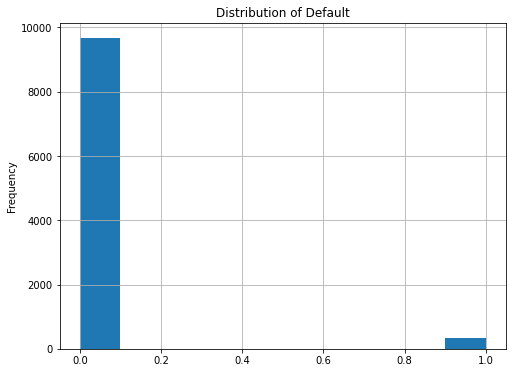

In [24]:
## check the distribution
df['default'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Default')
print(f"Proportion of observations who are default:{df['default'].sum() * 100 / df.shape[0]}%")

Proportion of observations who are students:29.44%


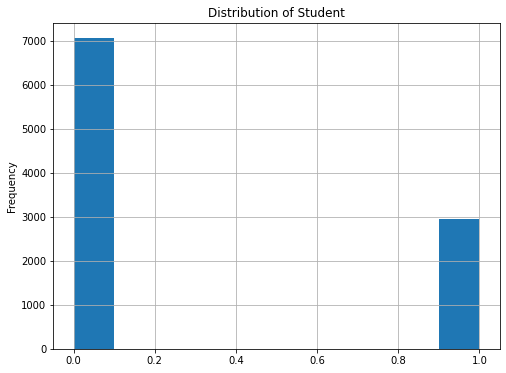

In [25]:
df['student'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Student')
print(f"Proportion of observations who are students:{df['student'].sum() * 100 / df.shape[0]}%")

Mean: 835.374885612557	Standard Deviation: 483.71498520561767


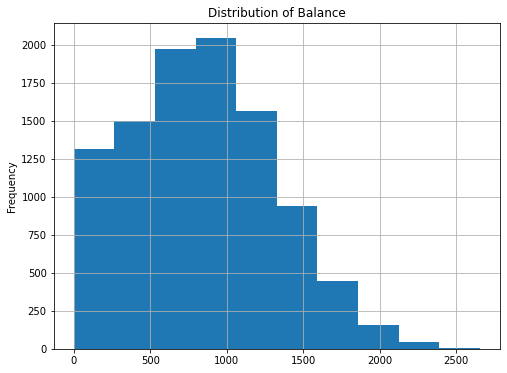

In [26]:
df['balance'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Balance')
print(f"Mean: {df['balance'].mean()}\tStandard Deviation: {df['balance'].std()}")

Mean: 33516.98187596067	Standard Deviation: 13336.639562689912


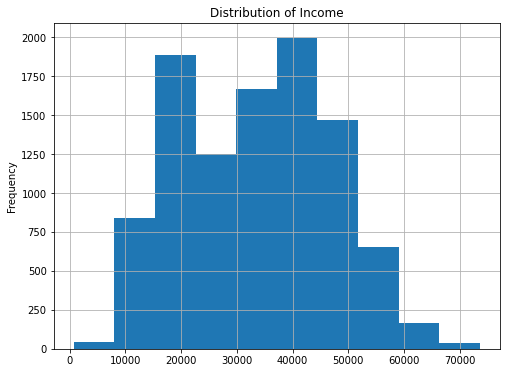

In [27]:
df['income'].plot(kind='hist', figsize=(8, 6), grid=True, title='Distribution of Income')
print(f"Mean: {df['income'].mean()}\tStandard Deviation: {df['income'].std()}")

In [28]:
# check correlation among the variables
df.corr()

,default,student,balance,income
default,1.000000,0.035420,0.350119,-0.019871
student,0.035420,1.000000,0.203578,-0.753985
balance,0.350119,0.203578,1.000000,-0.152243
income,-0.019871,-0.753985,-0.152243,1.000000


## Without Stratification

### Split train and validation

In [29]:
# Before split the data into train and test, let's split the data into X and y first.
X = df[['balance', 'income']]
y = df['default']

In [30]:
def split(X:Any, y:Any, test_size:float, random_state:int, shuffle:bool=True, stratify:bool=False):
    """
    X: pd.DataFrame or np.ndarray
    y: pd.DataFrame of np.ndarray
    """
    np.random.seed(random_state)

    X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
    idx = np.arange(y.shape[0], step=1)
    
    if stratify:
        classes = np.unique(y)
        val_idx = np.zeros(shape=(0, ))
        for c in classes:
            ind_c = np.where(y == c)[0]
            sample_size = np.around(ind_c.shape[0] * test_size, decimals=0).astype(np.int64)
            if shuffle:
                per_class = np.random.choice(ind_c, size=sample_size, replace=False)
            else:
                per_class = ind_c[-sample_size:]
            val_idx = np.append(val_idx, per_class)        
        
        train_idx = np.setdiff1d(idx, val_idx)
    
    else:
        sample_size = np.around(X.shape[0] * test_size, decimals=0).astype(np.int64)
        if shuffle:
            val_idx = np.random.choice(idx, size=sample_size, replace=False)
        else:
            val_idx = np.arange(start=X.shape[0]-sample_size, stop=X.shape[0], step=1)            
        train_idx = np.setdiff1d(idx, val_idx)     

    return train_idx, val_idx

In [31]:
train_idx, val_idx = split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=False)

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

print(f"train_idx:{train_idx}\tshape:{train_idx.shape[0]}\nval_idx:{val_idx}\tshape:{val_idx.shape[0]}")
print(f"\ny_train ones:{y_train.sum() / y_train.shape[0]}\ty_val ones:{y_val.sum() / y_val.shape[0]}")

train_idx:[   0    1    2 ... 9997 9998 9999]	shape:8000
val_idx:[3957 1944 3525 ... 7381 1267 8002]	shape:2000

y_train ones:0.033625	y_val ones:0.032


In [32]:
print(X_train.shape)
X_train.head()

(8000, 2)


,balance,income
0,729.526495,44361.625074
1,817.180407,12106.134700
2,1073.549164,31767.138947
3,529.250605,35704.493935
4,785.655883,38463.495879


In [33]:
print(X_val.shape)
X_val.head()

(2000, 2)


,balance,income
3957,2147.312578,58271.390826
1944,631.598011,46841.110964
3525,1955.557356,45507.911505
2998,1824.368004,20074.281097
6664,1411.548718,42956.631394


In [34]:
print(f"Proportion of observations who are default in the training set:{y_train.sum() * 100 / y_train.shape[0]:.3f}%")
y_train.head()

Proportion of observations who are default in the training set:3.362%


0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int64

In [35]:
print(f"Proportion of observations who are default in the test set:{y_val.sum() * 100 / y_val.shape[0]:.3f}%")
y_val.head()

Proportion of observations who are default in the test set:3.200%


3957    1
1944    0
3525    0
2998    0
6664    0
Name: default, dtype: int64

### (a) Fitting a logistic regression model

* I am going to use the function I have defined above.

In [36]:
## using statsmodels for interpretation
logistic = regression(X=X_train, y=y_train, constant=True, logit=True)
print(logistic.fit(disp=0).summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                  0.4831
Time:                        07:14:35   Log-Likelihood:                -608.35
converged:                       True   LL-Null:                       -1177.0
Covariance Type:            nonrobust   LLR p-value:                1.087e-247
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.0741      0.516    -23.409      0.000     -13.085     -11.063
balance        0.0059      0.000     22.094      0.000       0.005       0.006
income      2.186e-05   5.65e-06      3.870      0.0

* Both coefficients for explanatory variables are too low. This may attribute to the scale of those variables. So, let's see how to address the difference between packages, and the coefficients without the impact of the scale.

#### Optional

* Let's remove the impact of scales by normalization - specifically, from a variable, subtract its mean and divide it by its standard deviation.

In [37]:
def normalization(X:pd.Series) -> pd.Series:
    mean = X.mean()
    std = X.std()
    normalized = (X - X.mean()) / X.std()
    return normalized

In [38]:
train_idx, val_idx = X_train.index, X_val.index

copied = df.copy()
copied['balance'] = normalization(copied['balance'])
copied['income'] = normalization(copied['income'])

X_tr_copy, X_val_copy = copied[['balance', 'income']].loc[train_idx], copied[['balance', 'income']].loc[val_idx]
y_tr_copy, y_val_copy = copied['default'].loc[train_idx], copied['default'].loc[val_idx]
X_tr_copy.head()

,balance,income
0,-0.218824,0.813147
1,-0.037614,-1.605415
2,0.492386,-0.131206
3,-0.632861,0.164023
4,-0.102786,0.370897


In [39]:
y_val_copy.head()

3957    1
1944    0
3525    0
2998    0
6664    0
Name: default, dtype: int64

In [40]:
logistic_norm = regression(X=X_tr_copy, y=y_tr_copy, constant=True, logit=True)
print(logistic_norm.fit(disp=0).summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                  0.4831
Time:                        07:14:36   Log-Likelihood:                -608.35
converged:                       True   LL-Null:                       -1177.0
Covariance Type:            nonrobust   LLR p-value:                1.087e-247
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3717      0.225    -28.321      0.000      -6.813      -5.931
balance        2.8776      0.130     22.094      0.000       2.622       3.133
income         0.2916      0.075      3.870      0.0

* There are two interesting things here.
    - First, after removal of the impact of scale, the coefficients also changed compared to the first regression above. This seems obvious, since the scale of each variable has been modified to have the zero mean and a unit standard deviation. While more interesting thing is that even though the scale has been changed, whether each variable is significant or not has not changed.
    - Second, now the coefficients computed using the `statsmodels` library is different to those computed from the `scikit-learn` library. The reason seems to be the fact that the latter one implements the **'regularized' logistic regression** by default. According to the search result, the regularization is a technique used in machine learning to prevent the model from overfitting and underfitting. Since the main purpose of the `scikit-learn` library is to provide 'more accurate and reliable prediction', rather than to provide 'more strict interpretability', thus the model is set to be regularized by default.
        - By setting the model not to be regularized, it yields the same result as the `statsmodels` library does.

* Now, back to the problem.

### (a) Prediction and computation of validation error

* Continue prediction with `statsmodels`

In [41]:
params_nost = logistic.fit(disp=0).params
y_val_pred = logistic.predict(params=params_nost, exog=sm.add_constant(X_val))
y_val_pred

array([8.78061105e-01, 6.80078502e-04, 6.35155712e-01, ...,
       1.15636758e-01, 2.85795920e-04, 2.48566286e-02])

In [42]:
y_val_class = (y_val_pred > 0.5).astype(np.int16)
print(f"Validation error in terms of the misclassification rate: {classification_error(y_true=y_val, y_pred=y_val_class):.6f}")
print(f"Misclassification rate in percentage: {classification_error(y_true=y_val, y_pred=y_val_class) * 100:.3f}%")

Validation error in terms of the misclassification rate: 0.031500
Misclassification rate in percentage: 3.150%


### (c) $k$-fold Cross-validatoin

In [43]:
def manual_folds(X:Any, y:Any, random_state:int, n_splits:int=5, shuffle:bool=True, stratify:bool=False) -> List[np.ndarray]:
    """
    X: pd.DataFrame or np.ndarray
    y: pd.DataFrame or np.ndarray
    """
    np.random.seed(random_state)

    X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
    obs_per_fold = y.shape[0] // n_splits

    if stratify:
        classes = np.unique(y)
        idx_sets = [np.zeros(shape=(0, )) for i in range(n_splits)]
        remainder = []
        for c in classes:
            ind_c = np.where(y == c)[0]
            portion = ind_c.shape[0] / y.shape[0]
            sample_size = np.around(portion * obs_per_fold, decimals=0).astype(np.int64)
            for i in range(len(idx_sets)):
                fold_idx = idx_sets[i]
                if shuffle:
                    try:
                        per_class = np.random.choice(ind_c, size=sample_size, replace=False)
                    except:
                        per_class = np.random.choice(ind_c, size=ind_c.shape[0], replace=False)
                else:
                    per_class = ind_c[:sample_size]
                idx_sets[i] = np.append(fold_idx, per_class).astype(np.int64)
                ind_c = np.setdiff1d(ind_c, per_class)
            if ind_c.shape[0] > 0:
                remainder.append(ind_c)

        remainder = np.array(remainder, dtype=np.int64).flatten()
        diff = idx_sets[0].shape[0] - idx_sets[-1].shape[0]
        idx_sets[-1] = np.append(idx_sets[-1], remainder[:diff])
        for j in range(remainder[diff:].shape[0]):
            set_idx = j % n_splits
            idx_sets[n_splits-set_idx-1] = np.append(idx_sets[n_splits-set_idx-1], remainder[diff+j])

    else:
        idx = np.arange(y.shape[0], step=1)
        idx_sets = []
        if shuffle:
            while idx.shape[0] > obs_per_fold:
                fold_idx = np.random.choice(idx, size=obs_per_fold, replace=False)
                idx_sets.append(fold_idx)
                idx = np.setdiff1d(idx, fold_idx) # to remove the indices already chosen
        
        else:
            itr = 0
            while idx.shape[0] > obs_per_fold:
                fold_idx = np.arange(start=itr, stop=itr+obs_per_fold, step=1)
                idx_sets.append(fold_idx)
                idx = np.setdiff1d(idx, fold_idx) # to remove the indices already chosen
                itr += obs_per_fold

        if idx.shape[0] == obs_per_fold: # if (# of obs) % n_splits == 0
            idx_sets.append(idx)
        else:
            diff = idx_sets[0].shape[0] - idx_sets[-1].shape[0]
            idx_sets[-1] = np.append(idx_sets[-1], idx[:diff])
            for j in range(idx[diff:].shape[0]):
                set_idx = j % n_splits
                idx_sets[n_splits-set_idx-1] = np.append(idx_sets[n_splits-set_idx-1], idx[diff+j])

    return idx_sets

In [44]:
cv_indices = manual_folds(X=X, y=y, random_state=RANDOM_STATE, shuffle=True, stratify=True, n_splits=9)
print(len(cv_indices))
for item in cv_indices:
    y_cv = y.iloc[item]
    print(f"length of indices:{len(item)}\nindex values:{item}")
    print(f"portion of one in item:{y_cv.sum() / y_cv.shape[0]}\n")

9
length of indices:1111
index values:[4315 7402 3880 ... 7813 8456 3881]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[6348 3922 1424 ... 2201  487 9654]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[7689 9492 9852 ... 1709  761  981]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[1880 6817 3256 ...  263 9084 3376]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[6401 9100 4986 ... 5049  209 3437]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[6725 5672 2842 ... 1445 1447 1209]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[5630 9703 4969 ... 9949 6794 8264]
portion of one in item:0.0333033303330333

length of indices:1111
index values:[6955 4551 4207 ... 4594 6923 7827]
portion of one in item:0.0333033303330333

length of indices:1112
index values:[3064 5881 3539 ... 6333 1361  657]
portio

In [45]:
def cross_val(X:Any, y:Any, scoring:Callable, random_state:int, cv:int=5, shuffle:bool=True, stratify:bool=False, verbose:bool=True, metric:str=None) -> List[float]:
    """
    X, y: pd.DataFrame or np.ndarray
    """
    if type(X) != pd.DataFrame and type(X) != np.ndarray:
        raise TypeError("The data should be either a pandas dataframe or a numpy array.")
    
    scores = []
    cv_indices = manual_folds(X=X, y=y, random_state=random_state, n_splits=cv, shuffle=shuffle, stratify=stratify)
    for i in range(len(cv_indices)):
        copied = cv_indices[:] # copy
        val_idx = copied.pop(i)
        train_idx = np.array(copied, dtype=np.int64).flatten()
        
        if type(X) == pd.DataFrame:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        elif type(X) == np.ndarray:
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

        logit_cv = regression(X=X_train, y=y_train, constant=True, logit=True)
        params_cv = logit_cv.fit(disp=0).params
        y_val_pred_cv = logit_cv.predict(params=params_cv, exog=sm.add_constant(X_val))
        y_val_pred_cv_class = (y_val_pred_cv > 0.5).astype(np.int16)
        
        if scoring.__name__ == "class_metrics":
            val_score = scoring(y_val, y_val_pred_cv_class, metric=metric)
        else:
            val_score = scoring(y_val, y_val_pred_cv_class)
        scores.append(val_score)
        if verbose:
            print(f"Trial {i+1}\tCV score:{val_score:.6f}")

    return scores

In [46]:
scores = cross_val(X=X, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5)
print(f"\nTotal cross-validation error: {np.mean(scores):.6f}")

Trial 1	CV score:0.031500
Trial 2	CV score:0.022000
Trial 3	CV score:0.018500
Trial 4	CV score:0.028000
Trial 5	CV score:0.031500

Total cross-validation error: 0.026300


### (d) Including the `Student`

In [47]:
X_mod = df[['student', 'balance', 'income']]
X_mod.head()

,student,balance,income
0,0,729.526495,44361.625074
1,1,817.180407,12106.134700
2,0,1073.549164,31767.138947
3,0,529.250605,35704.493935
4,0,785.655883,38463.495879


In [48]:
scores = cross_val(X=X_mod, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5)
print(f"\nTotal cross-validation error: {np.mean(scores):.6f}")

Trial 1	CV score:0.031000
Trial 2	CV score:0.023500
Trial 3	CV score:0.019500
Trial 4	CV score:0.029000
Trial 5	CV score:0.032500

Total cross-validation error: 0.027100


#### Verification

In [49]:
X_mod = df[['student', 'balance']]
X_mod.head()

,student,balance
0,0,729.526495
1,1,817.180407
2,0,1073.549164
3,0,529.250605
4,0,785.655883


In [50]:
scores = cross_val(X=X_mod, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5)
print(f"\nTotal cross-validation error: {np.mean(scores):.6f}")

Trial 1	CV score:0.031000
Trial 2	CV score:0.023000
Trial 3	CV score:0.019500
Trial 4	CV score:0.029000
Trial 5	CV score:0.032500

Total cross-validation error: 0.027000


In [51]:
X_mod = df[['student', 'income']]
X_mod.head()

,student,income
0,0,44361.625074
1,1,12106.134700
2,0,31767.138947
3,0,35704.493935
4,0,38463.495879


In [52]:
scores = cross_val(X=X_mod, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5)
print(f"\nTotal cross-validation error: {np.mean(scores):.6f}")

Trial 1	CV score:0.032000
Trial 2	CV score:0.031500
Trial 3	CV score:0.030500
Trial 4	CV score:0.034000
Trial 5	CV score:0.038500

Total cross-validation error: 0.033300


### Precision and Recall

#### Hold-out

In [53]:
precision = class_metrics(y_true=y_val, y_pred=y_val_class, metric='precision')
recall = class_metrics(y_true=y_val, y_pred=y_val_class, metric='recall')
fpr = class_metrics(y_true=y_val, y_pred=y_val_class, metric='fpr')
fnr = class_metrics(y_true=y_val, y_pred=y_val_class, metric='fnr')

print(f"Under Hold-out validation\n\tPrecision\t{precision:.4f}\n\tRecall\t\t{recall:.4f}\n\tFPR\t\t{fpr:.4f}\n\tFNR\t\t{fnr:.4f}")

Under Hold-out validation
	Precision	0.5185
	Recall		0.2188
	FPR		0.0067
	FNR		0.7812


#### Cross-Validation

In [54]:
precision_cv = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='precision', verbose=False)
recall_cv = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='recall', verbose=False)
fpr_cv = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='fpr', verbose=False)
fnr_cv = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='fnr', verbose=False)

print(f"Under Cross-validation\n\tPrecision\t{np.mean(precision_cv):.4f}\n\tRecall\t\t{np.mean(recall_cv):.4f}")
print(f"\tFPR\t\t{np.mean(fpr_cv):.4f}\n\tFNR\t\t{np.mean(fnr_cv):.4f}")

Under Cross-validation
	Precision	0.7382
	Recall		0.3276
	FPR		0.0039
	FNR		0.6724


In [55]:
precision_cv = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='precision', verbose=False)
recall_cv = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='recall', verbose=False)
fpr_cv = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='fpr', verbose=False)
fnr_cv = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, cv=5, metric='fnr', verbose=False)

print(f"Under Cross-validation\n\tPrecision\t{np.mean(precision_cv):.4f}\n\tRecall\t\t{np.mean(recall_cv):.4f}")
print(f"\tFPR\t\t{np.mean(fpr_cv):.4f}\n\tFNR\t\t{np.mean(fnr_cv):.4f}")

Under Cross-validation
	Precision	nan
	Recall		0.0000
	FPR		0.0000
	FNR		1.0000


### f1_score

#### Hold-out

In [56]:
print(f"Under Hold-out validation\n\tF1-score\t{f1_score(y_true=y_val, y_pred=y_val_class):.4f}")

Under Hold-out validation
	F1-score	0.3077


#### Cross-Validation

In [57]:
f1_cv = cross_val(X=X, y=y, scoring=f1_score, random_state=RANDOM_STATE, cv=5, verbose=False)
print(f"Under Cross-validation\n\tF1-score\t{np.mean(f1_cv):.4f}")

Under Cross-validation
	F1-score	0.4528


In [58]:
f1_cv = cross_val(X=X_mod, y=y, scoring=f1_score, random_state=RANDOM_STATE, cv=5, verbose=False)
print(f"Under Cross-validation\n\tF1-score\t{np.mean(f1_cv):.4f}")

Under Cross-validation
	F1-score	nan


## With Stratification

### Hold-out

In [59]:
train_st_idx, val_st_idx = split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=True)

X_st_train, X_st_val = X.iloc[train_st_idx], X.iloc[val_st_idx]
y_st_train, y_st_val = y.iloc[train_st_idx], y.iloc[val_st_idx]

print(f"train_idx:{train_st_idx}\tshape:{train_st_idx.shape[0]}\nval_idx:{val_st_idx}\tshape:{val_st_idx.shape[0]}")
print(f"\ny_train ones:{y_st_train.sum() / y_st_train.shape[0]}\ty_val ones:{y_st_val.sum() / y_st_val.shape[0]}")

train_idx:[   0    1    2 ... 9997 9998 9999]	shape:8000
val_idx:[4315. 7402. 3880. ... 4708.  136. 1255.]	shape:2000

y_train ones:0.03325	y_val ones:0.0335


In [60]:
logistic_st = regression(X=X_st_train, y=y_st_train, constant=True, logit=True)
params_st = logistic_st.fit(disp=0).params
y_st_val_pred = logistic_st.predict(params=params_st, exog=sm.add_constant(X_st_val))
y_st_val_pred

array([3.07560266e-05, 5.93467716e-03, 3.87632984e-04, ...,
       1.52297667e-01, 5.89972559e-02, 7.07648976e-01])

In [61]:
y_st_val_class = (y_st_val_pred > 0.5).astype(np.int16)
print(f"Validation error in terms of the misclassification rate: {classification_error(y_true=y_st_val, y_pred=y_st_val_class):.6f}")
print(f"Misclassification rate in percentage: {classification_error(y_true=y_st_val, y_pred=y_st_val_class) * 100:.3f}%")

Validation error in terms of the misclassification rate: 0.025000
Misclassification rate in percentage: 2.500%


### Cross-validation

In [62]:
scores_st = cross_val(X=X, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5, stratify=True)
print(f"\nTotal cross-validation error: {np.mean(scores_st):.6f}")

Trial 1	CV score:0.023000
Trial 2	CV score:0.027000
Trial 3	CV score:0.027500
Trial 4	CV score:0.030000
Trial 5	CV score:0.023500

Total cross-validation error: 0.026200


### Including the `Student`

In [63]:
X_mod = df[['student', 'balance', 'income']]
X_mod.head()

,student,balance,income
0,0,729.526495,44361.625074
1,1,817.180407,12106.134700
2,0,1073.549164,31767.138947
3,0,529.250605,35704.493935
4,0,785.655883,38463.495879


In [64]:
scores_st = cross_val(X=X_mod, y=y, scoring=classification_error, random_state=RANDOM_STATE, cv=5, stratify=True)
print(f"\nTotal cross-validation error: {np.mean(scores_st):.6f}")

Trial 1	CV score:0.023000
Trial 2	CV score:0.027500
Trial 3	CV score:0.027000
Trial 4	CV score:0.032000
Trial 5	CV score:0.023500

Total cross-validation error: 0.026600


### Precision and Recall

#### Hold-out

In [65]:
precision_st = class_metrics(y_true=y_st_val, y_pred=y_st_val_class, metric='precision')
recall_st = class_metrics(y_true=y_st_val, y_pred=y_st_val_class, metric='recall')
fpr_st = class_metrics(y_true=y_st_val, y_pred=y_st_val_class, metric='fpr')
fnr_st = class_metrics(y_true=y_st_val, y_pred=y_st_val_class, metric='fnr')

print(f"Under Hold-out validation\n\tPrecision\t{precision_st:.4f}\n\tRecall\t\t{recall_st:.4f}")
print(f"\tFPR\t\t{fpr_st:.4f}\n\tFNR\t\t{fnr_st:.4f}")

Under Hold-out validation
	Precision	0.7742
	Recall		0.3582
	FPR		0.0036
	FNR		0.6418


#### Cross-Validation

In [66]:
precision_cv_st = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                         cv=5, metric='precision', stratify=True, verbose=False)
recall_cv_st = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                      cv=5, metric='recall', stratify=True, verbose=False)
fpr_cv_st = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                   cv=5, metric='fpr', stratify=True, verbose=False)
fnr_cv_st = cross_val(X=X, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                   cv=5, metric='fnr', stratify=True, verbose=False)

print(f"Under Cross-validation\n\tPrecision\t{np.mean(precision_cv_st):.4f}\n\tRecall\t\t{np.mean(recall_cv_st):.4f}")
print(f"\tFPR\t\t{np.mean(fpr_cv_st):.4f}\n\tFNR\t\t{np.mean(fnr_cv_st):.4f}")

Under Cross-validation
	Precision	0.7400
	Recall		0.3246
	FPR		0.0038
	FNR		0.6754


In [67]:
precision_cv_st = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                            cv=5, metric='precision', stratify=True, verbose=False)
recall_cv_st = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                         cv=5, metric='recall', stratify=True, verbose=False)
fpr_cv_st = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                      cv=5, metric='fpr', stratify=True, verbose=False)
fnr_cv_st = cross_val(X=X_mod, y=y, scoring=class_metrics, random_state=RANDOM_STATE, 
                      cv=5, metric='fnr', stratify=True, verbose=False)

print(f"Under Cross-validation\n\tPrecision\t{np.mean(precision_cv_st):.4f}\n\tRecall\t\t{np.mean(recall_cv_st):.4f}")
print(f"\tFPR\t\t{np.mean(fpr_cv_st):.4f}\n\tFNR\t\t{np.mean(fnr_cv_st):.4f}")

Under Cross-validation
	Precision	0.7207
	Recall		0.3186
	FPR		0.0040
	FNR		0.6814


### f1_score

#### Hold-out

In [68]:
print(f"Under Hold-out validation\n\tF1-score\t{f1_score(y_true=y_st_val, y_pred=y_st_val_class):.4f}")

Under Hold-out validation
	F1-score	0.4898


#### Cross-Validation

In [69]:
f1_st_cv = cross_val(X=X, y=y, scoring=f1_score, random_state=RANDOM_STATE, cv=5, stratify=True, verbose=False)
print(f"Under Cross-validation\n\tF1-score\t{np.mean(f1_st_cv):.4f}")

Under Cross-validation
	F1-score	0.4496


In [70]:
f1_st_cv = cross_val(X=X_mod, y=y, scoring=f1_score, random_state=RANDOM_STATE, stratify=True, cv=5, verbose=False)
print(f"Under Cross-validation\n\tF1-score\t{np.mean(f1_st_cv):.4f}")

Under Cross-validation
	F1-score	0.4403
